In [260]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import wandb
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torchvision import datasets, transforms
from torch.utils.data import random_split, Subset

In [311]:
wandb.login(key = "")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [69]:
@dataclass

class Config:

  lr = 5e-3
  epochs: int = 3
  device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [251]:
# Transformation (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download + load training dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


# Download + load test dataset
valid_datas = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
valid_indices = torch.randperm(len(valid_data))[:10000]
valid_data = Subset(valid_datas, valid_indices)

test_indices = torch.randperm(len(valid_datas))[:5000]
test_data = Subset(valid_datas, test_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_data, batch_size=12, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [346]:
class Model(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3)
        self.norm1 = nn.LayerNorm(256, 0.00001)
        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.LeakyReLU(0.0001)

        self.ffnn1 = nn.Linear(768, 256)
        self.cls_head = nn.Linear(256, 10)

    def forward(self, x, target = None):

        B, C, H, W = x.size()
        feature_map1 = self.pool(self.relu(self.conv1(x)))
        feature_map2 = self.pool(self.relu(self.conv2(feature_map1)))

        flattened = feature_map2.reshape(B, -1)

        feature1 = self.norm1(self.relu(self.ffnn1(flattened)))
        logits = self.cls_head(feature1)

        loss = None
        actual = None

        if target is not None:
          loss = nn.CrossEntropyLoss()(logits, target.reshape(-1))
          actual = torch.argmax(logits, dim = -1)
          total_correct = torch.sum((actual.reshape(-1) == target.reshape(-1)).long()).item()
          total = len(actual.reshape(-1))
          accuracy = total_correct/total

        return logits, loss, accuracy

In [347]:
model = Model(config=config).to(config.device)

In [348]:
print(f'''\n total-parameters: {sum(p.numel() for p in model.parameters())/1e6 :.5f} Millions\n''')


 total-parameters: 0.21542 Millions



In [349]:
optimizers = torch.optim.AdamW(model.parameters(), lr = config.lr)

In [350]:
run = wandb.init(
    name = "threshold-training-prunning",
    config=vars(config),
)

In [353]:
def percentile_prunning_threshold(model, percentile: float):
  temp = torch.rand(5)

  for name, modules in model.named_modules():
    if isinstance(modules, nn.Linear):
      if len(temp)==5:
        temp = torch.abs(modules.weight.data).reshape(-1)
      else:
        torch.cat((temp, torch.abs(modules.weight.data).reshape(-1)), dim = -1)

  k = int(percentile * temp.numel())
  return torch.kthvalue(temp, k).values.item()

In [354]:
valid_step = 400

for epoch in tqdm(range(config.epochs), desc = f"Epochs "):

    run.log({"epochs": epoch+1})

    valid_init = 0
    model.train()
    for i, batch in enumerate(train_loader):
      valid_init +=1
      X, y = batch
      X, y = X.to(config.device), y.to(config.device)
      cls, loss, accuracy_score = model(X, y)

      if i % 300==0:
        run.log({"train-batch-loss": loss, "batch-train-accuracy": accuracy_score})

      optimizers.zero_grad()
      loss.backward()
      optimizers.step()

      # percentile-wise-threshold-prunning.
      for name, modules in model.named_modules():
        if isinstance(modules, nn.Linear):
          threshold_value = percentile_prunning_threshold(model, 0.2)
          mask = (torch.abs(modules.weight.data) > threshold_value).float()
          modules.weight.data = mask * modules.weight.data

      if (valid_init+1)%valid_step==0:
        model.eval()
        valid_loss = 0
        valid_size = 0
        accuracy_score = 0
        with torch.no_grad():
          for i, batch in enumerate(valid_data):
            X, y = batch
            X, y = X.to(config.device), y.to(config.device)
            _, loss, accuracy_score = model(X, y)
            if i % 100==0:
              run.log({"per-batch-valid-accuracy": accuracy_score})
            valid_loss +=loss.item()
            valid_size +=X.size(0)

          batch_valid_loss = valid_loss / valid_size

          run.log({"valid-after-batch-loss": batch_valid_loss})

run.finish()

Epochs : 100%|██████████| 3/3 [01:13<00:00, 24.45s/it]


batch-train-accuracy,▁▁██▇█████████████████
epochs,▁▁▅█
per-batch-valid-accuracy,▁▁▁▁▁▁▁▁▁▁▁▁
train-batch-loss,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid-after-batch-loss,▄█▁▁▁▁▁▁▁▁▁▁
batch-train-accuracy,0.9375
epochs,3
per-batch-valid-accuracy,1
train-batch-loss,0.12389
valid-after-batch-loss,0.00023


In [310]:
'''MANUAL-THRESHOLD-PRUNNING'''

# for name, modules in model.named_modules():
#   if isinstance(modules, nn.Linear):
#     mask = (torch.abs(modules.weight.data) > 0.05).long()
#     modules.weight.data = mask * modules.weight.data

'MANUAL-THRESHOLD-PRUNNING'

In [355]:
for name, modules in model.named_modules():
  if isinstance(modules, nn.Linear):
    print(modules.weight.data)

tensor([[-0.0319, -0.0073, -0.0246,  ..., -0.0237, -0.1247, -0.1348],
        [-0.0182,  0.0080,  0.0000,  ..., -0.1262, -0.1269,  0.2070],
        [-0.0000, -0.0000, -0.0372,  ...,  0.3194,  0.0650, -0.0835],
        ...,
        [-0.0312, -0.0232, -0.0000,  ..., -0.1074,  0.1082,  0.2040],
        [ 0.0000,  0.0434,  0.0077,  ...,  0.0273,  0.1095,  0.5307],
        [-0.0000,  0.0000, -0.0471,  ..., -0.0454, -0.0539, -0.0107]],
       device='cuda:0')
tensor([[-0.3778, -0.1778,  0.2445,  ...,  0.1130, -0.2686, -0.0035],
        [-0.0364, -0.1614, -0.2635,  ..., -0.0563,  0.1901, -0.0027],
        [-0.0698,  0.3093, -0.0524,  ...,  0.3653,  0.1596, -0.0017],
        ...,
        [ 0.0353,  0.2147, -0.1094,  ...,  0.0359, -0.1348, -0.0153],
        [-0.1368, -0.1852, -0.2563,  ...,  0.0031,  0.0435,  0.0005],
        [ 0.1530, -0.1989, -0.1703,  ..., -0.0532, -0.1119,  0.0061]],
       device='cuda:0')


In [356]:
for k, batch in enumerate(test_loader):
  X, y = batch
  X, y = X.to(config.device), y.to(config.device)
  logits, loss, acc = model(X, y)

  #print(f'{torch.argmax(logits, dim = -1).item()} | {y.item()}')
print(f"Loss: {loss:.2f}, Accuracy-Score: {acc}")

Loss: 0.00, Accuracy-Score: 1.0




Layer: ffnn1
MEAN: -0.00944


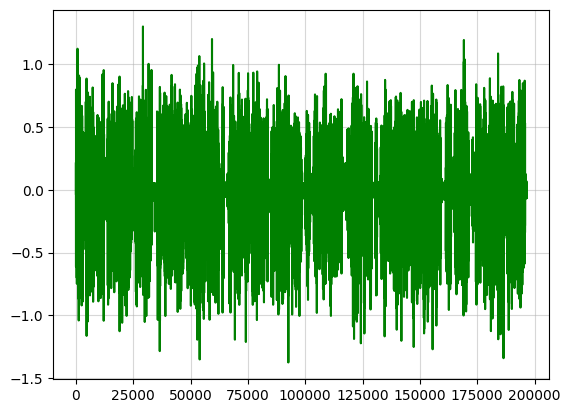



Layer: cls_head
MEAN: -0.02585


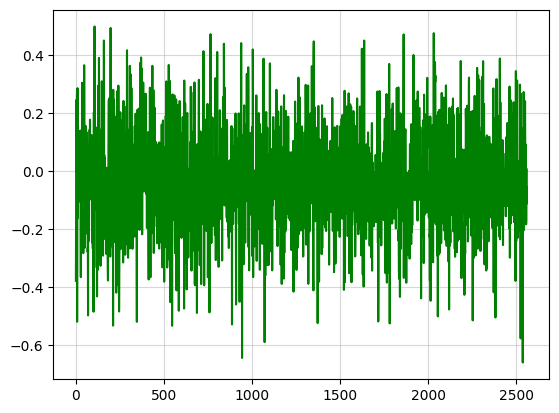

In [357]:
for name, modules in model.named_modules():

  if isinstance(modules, nn.Linear):
    weights = modules.weight.data
    plt.plot(weights.reshape(-1).cpu().detach(), color = 'green')
    print(f"\n\nLayer: {name}")
    plt.grid(True, alpha = 0.5)
    print(f'MEAN: {torch.mean(weights.reshape(-1).cpu().detach()).item():.5f}')
    plt.show()